In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.colors as pc
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D 

In [19]:
df = pd.read_csv("HC_Clean.csv")

In [20]:
pca = PCA()
customers_pca = pca.fit_transform(df)

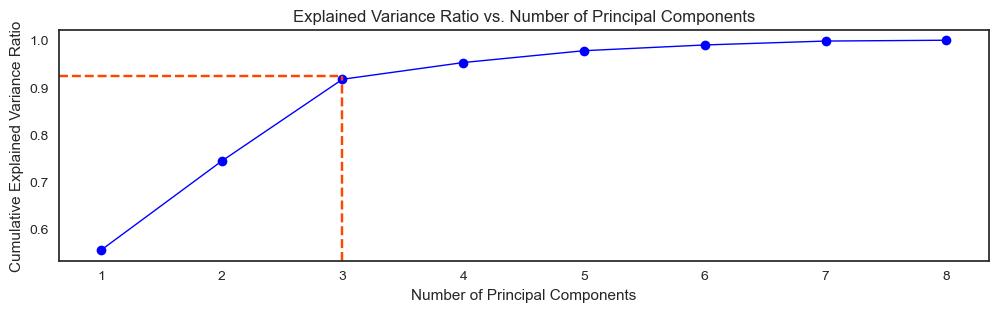

In [21]:
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize = (12, 3))
sns.set_style('white')
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker = 'o', color = 'blue', linewidth = 1)
plt.axvline(3, 0, 0.8, color = 'orangered', linestyle = '--')
plt.axhline(0.925, 0, 0.3, color = 'orangered', linestyle = '--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()

In [22]:
pca = PCA(n_components = 3)
customers_pca = pca.fit_transform(df)
loadings = pd.DataFrame(pca.components_, columns = df.columns[0:])

In [23]:
fig = px.scatter_3d(customers_pca, 
        x = customers_pca[:, 0], 
        y = customers_pca[:, 1], 
        z = customers_pca[:, 2],
        template = 'plotly_white',
        labels = {'x': 'PC0', 'y': 'PC1', 'z': 'PC2'})

scaler = 1.2

for i in range(len(loadings.columns)):
    fig.add_trace(go.Scatter3d(
        x = [0, loadings.iloc[0, i] * scaler],
        y = [0, loadings.iloc[1, i] * scaler],
        z = [0, loadings.iloc[2, i] * scaler],
        mode = 'lines+text',
        text = ['', f'{loadings.columns[i]}'],
        textposition = 'top center',
        textfont = dict(color = 'green'),
        line = dict(color = 'red', width = 6),
        showlegend = False
    ))

fig.update_traces(
    marker = dict(size = 6, opacity = 0.5),
    hovertemplate = '<br>PC0: %{x}<br>PC1: %{y}<br>PC2: %{z}<extra></extra>',
    selector = dict(type = 'scatter3d')
)

fig.update_layout(
    margin = dict(l = 0, r = 0, b = 0, t = 0),
    title = {
        'text': '3D Biplot',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [24]:
def visualizing_silhouette_plot(data_arr, method):
    silh_scores = []
    k = range(2, 10)

    for n in k:
        m = method(n_clusters = n)
        m.fit(data_arr)
        labels = m.labels_
        silh_scores.append(silhouette_score(data_arr, labels, metric = 'euclidean'))

    plt.figure(figsize = (12, 3))
    sns.set_style('white')
    plt.plot(k, silh_scores, marker='o', color = 'blue', alpha = 0.8, linewidth = 1)
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title(f'Silhouette analysis for optimal k')
    plt.show()

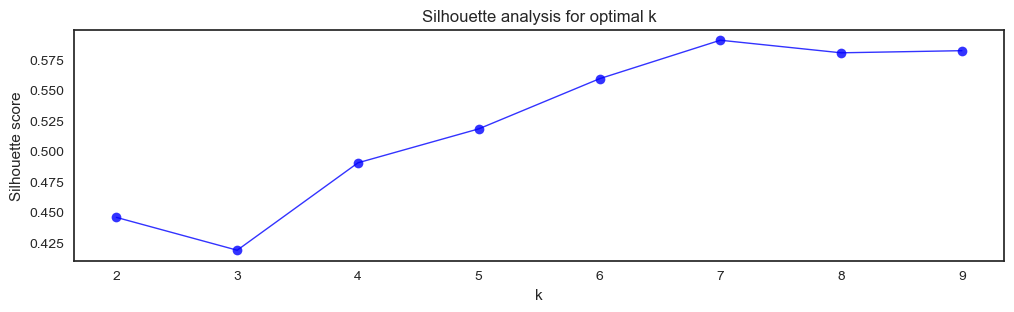

In [25]:
visualizing_silhouette_plot(customers_pca, KMeans)

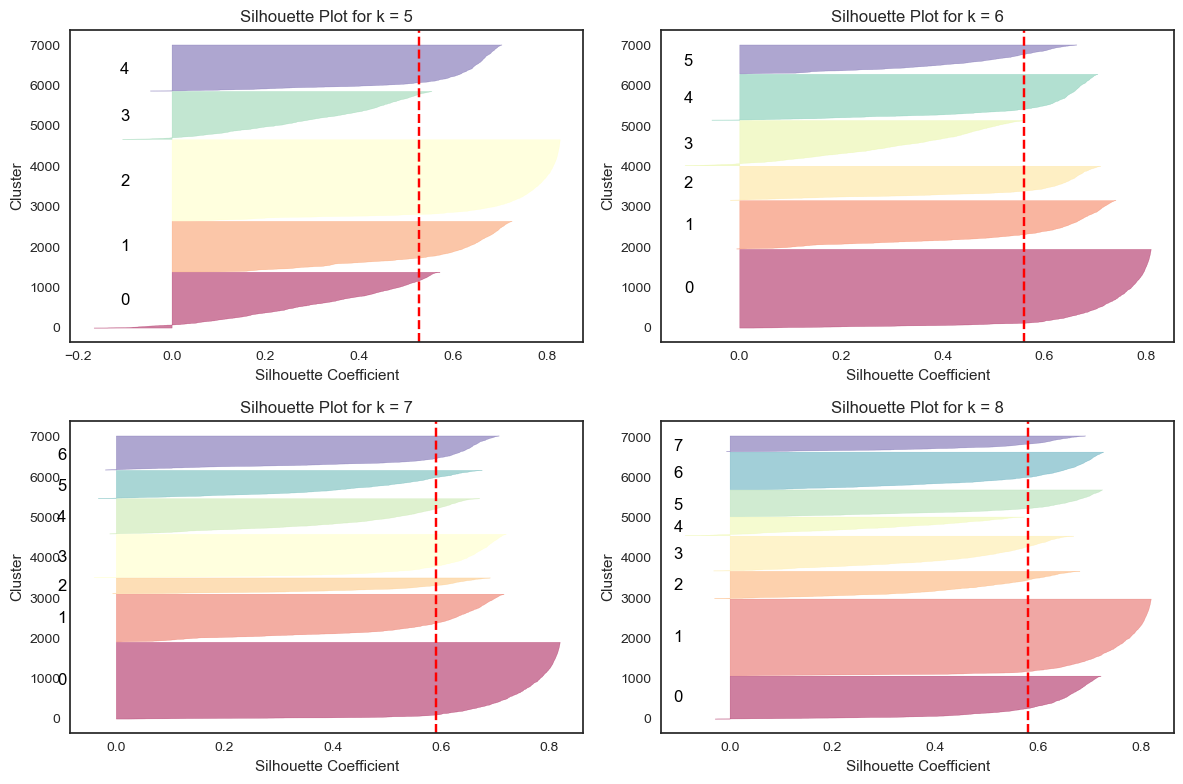

In [26]:
sns.set_style('white')
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, k in enumerate(range(5, 9)):
    km = KMeans(n_clusters = k, init='k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)
    sv = SilhouetteVisualizer(km, colors='Spectral', ax = ax[q, mod])
    sv.fit(customers_pca)
    
    ax[q, mod].set_xlabel('Silhouette Coefficient')
    ax[q, mod].set_ylabel('Cluster')
    ax[q, mod].set_title(f'Silhouette Plot for k = {k}')
    
    for cluster in range(k):
        y_lower = sum(len(customers_pca[km.labels_ == j]) for j in range(cluster))
        y_upper = y_lower + len(customers_pca[km.labels_ == cluster])
        y_avg = (y_lower + y_upper) / 2

        ax[q, mod].text(-0.1, y_avg, str(cluster), va = 'center', ha = 'center', fontsize = 12, color = 'black')

plt.tight_layout()
plt.show()

In [27]:
def visualizing_3d_clusters(data_arr, clusters, centroids, title):
    colors = px.colors.qualitative.Pastel

    hovertext = ['Cluster: {}'.format(cluster) for cluster in clusters]

    fig = px.scatter_3d(data_arr, 
                x = customers_pca[:, 0], 
                y = customers_pca[:, 1], 
                z = customers_pca[:, 2],
                color = clusters,
                template = 'plotly_white',
                color_discrete_sequence = colors,
                labels={'x': 'PC0', 'y': 'PC1', 'z': 'PC2'})

    fig.update_traces(
                marker = dict(size = 6,
                line = dict(width=0.1,
                color = 'DarkSlateGrey')),
                hovertemplate = '<b>%{text}</b><br>PC0: %{x}<br>PC1: %{y}<br>PC2: %{z}<extra></extra>',
                text = hovertext,
                selector = dict(type = 'scatter3d'))

    if centroids is not None:
        centroids_trace = go.Scatter3d(
                    x = centroids[:, 0], 
                    y = centroids[:, 1], 
                    z = centroids[:, 2],
                    mode = 'markers',
                    marker = dict(size=5, color='red', symbol='x'),
                    name = 'Centroids',
                    hovertemplate = '<b>Centroid</b><br>PC0: %{x}<br>PC1: %{y}<br>PC2: %{z}<extra></extra>')

        fig.add_trace(centroids_trace)

    fig.update_layout(
                margin = dict(l = 0, r = 0, b = 0, t = 0),
                title = {
                    'text': title,
                    'y': 0.9,
                    'x': 0.5,
                    'xanchor': 'right',
                    'yanchor': 'top'},
                legend_title = "clusters",
                legend = dict(
                    yanchor = "top",
                    y = 0.99,
                    xanchor = "right",
                    x = 0.01),
                showlegend = True)
    
    fig.show()

In [30]:
km = KMeans(n_clusters = 6)
clusters_km = km.fit_predict(customers_pca).astype(str)
centroids_km = km.cluster_centers_

In [31]:
visualizing_3d_clusters(customers_pca, clusters_km, centroids_km, 'K-Means Clustering')